In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
os.chdir("..")

# import sys
# sys.path.append("./vrevals")

import re
import ast
import json
import numpy as np
import pandas as pd
import yaml
import time
import glob

import matplotlib.pyplot as plt

from collections import Counter
from src.utils.math_equivalence import is_math_equiv, extract_boxed_answer
from src.utils.pass_k_utils import estimate_pass_at_k

In [2]:
from transformers import AutoTokenizer

model_name = "Qwen/Qwen2.5-7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
class Args:
    dataset_name = "open"
    # dataset_name = "gsm8k"
    split = "p1"
    subset_num = None
    step_by_step_prompt = True
    n_threads = 1
args = Args()
job_dir = f"runs/{args.dataset_name}.qwen2.5-0.5b"
sampler_config_dir = f'{job_dir}/sft_ep*.direct/sample_1'
prompt_csv_path = f'{job_dir}/{args.split}.prompts.csv'
print(sampler_config_dir)

runs/open.qwen2.5-0.5b/sft_ep*.direct/sample_1


In [5]:
all_generation_csv = glob.glob(f"{sampler_config_dir}/{args.split}.generations*.csv")


In [6]:
all_generation_df = []
for csv_path in all_generation_csv:
    epoch_match = re.search(r'ep(\d+)', csv_path)
    if epoch_match:
        epoch_num = int(epoch_match.group(1))
    else:
        epoch_num = None
    temp_df = pd.read_csv(csv_path)
    temp_df['epoch'] = epoch_num
    all_generation_df.append(temp_df)

In [ ]:
# all_generation_csv = glob.glob(f"{sampler_config_dir}/generations*.csv")
# Concatenate all dataframes in all_generation_df into a single dataframe
generation_df = pd.concat(all_generation_df, ignore_index=True)

def extract_prefix(row):
    # response = row['response']
    # first_token = tokenizer.tokenize(response[:50])[0]

    prefix = ast.literal_eval(row['sampler_config'].strip())['sampler'].get('thinking_prefix', "")
    # print(eval(row['sampler_config'].strip()).get('thinking_prefix', "default"))
    return prefix

generation_df['prefix'] = generation_df.apply(extract_prefix, axis=1)
generation_df['response'] = generation_df['response'].apply(lambda x: x.split(".")[0])

# generation_df['pred_answer'] = generation_df.response.apply(extract_boxed_answer)
# generation_df['is_valid'] = generation_df.pred_answer.apply(lambda x: len(x) > 0)
# generation_df['is_correct'] = generation_df.apply(lambda row: is_math_equiv(str(row['gt_answer']), str(row['pred_answer'])), axis=1)

In [8]:
generation_df

,question_id,prompt_id,response,pred_answer,gt_answer,sampler_config,epoch,prefix
0,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why did the electric car turn away from the ga...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",3,default
1,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why did the electric car need a battery?\nBeca...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",3,default
2,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why don't electric cars like to play with snow...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",3,default
3,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why did the electric car go to the mechanic fo...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",3,default
4,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why was the battery sad when the electric car ...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",3,default
...,...,...,...,...,...,...,...,...
6139,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why don't electric cars ever need to pay for t...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",2,default
6140,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why was the electric car at the grocery store?...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",2,default
6141,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why don't electric cars have lawyers? Because ...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",2,default
6142,imo-bench-combinatorics-005,imo-bench-combinatorics-005,Why did the electric car break down? Because i...,NaN,1431655765,"{'sampler': {'class': 'VLLMSampler', 'model_na...",2,default


#### Dataset for Gvendi

In [44]:
prompt_csv_path

'runs/imobench.qwen2.5-0.5b/p1.prompts.csv'

In [45]:
prompts_df = pd.read_csv(prompt_csv_path)
prompts = {}
for _, row in prompts_df.iterrows():
    prompts[row['prompt_id']] = row['question']

dataset = []
for row_id, row in generation_df.iterrows():
    dataset.append({
        "id": row_id,
        "prompt": prompts[row['prompt_id']],
        "completion": row['prefix'] + row['response'],
        "prefix": row['prefix'],
        "epoch": row['epoch'],
    })

In [47]:
# Save the dataset as a jsonline file
with open("/home/nlp/hnn5071/datasets/imo-bench-combinatorics-005.sft.approach_prompting.jsonl", mode="w") as f:
    for record in dataset:
        f.write(json.dumps(record) + "\n")

In [11]:
# grouped_df = generation_df.groupby(['question_id', 'prompt_id', 'gt_answer'])

# # responses = grouped_df.response.apply(list).reset_index(name='text')
# pred_answers = grouped_df.pred_answer.apply(list).reset_index(name='text')
# # Count the number of unique values in pred_answers for each question
# # pred_answers['text'] = pred_answers['text'].apply(lambda x: list(filter(lambda i: i != '', x)))
# # pred_answers['num_valid_samples'] = pred_answers['text'].apply(len)
# # pred_answers['num_unique_answers'] = pred_answers['text'].apply(lambda x: len(set(x)))
# # pred_answers['fraction_unique_pred_answers'] = pred_answers['text'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
# pred_answers['fraction_correct_pred'] = grouped_df.is_correct.apply(lambda x: sum(x) / len(x)).values

In [12]:
# pred_answers

In [13]:
# plt.figure(figsize=(8, 5))
# plt.hist(
#     pred_answers[pred_answers['prefix'] == "To" ]['fraction_correct_pred'],
#     bins=20,
#     edgecolor='black',
#     range=(0, 1)
# )

# # plt.hist(
# #     pred_answers[pred_answers['prefix'] == "Given" ]['fraction_correct_pred'],
# #     bins=20,
# #     edgecolor='black',
# #     range=(0, 1)
# # )

# # plt.hist(
# #     pred_answers[pred_answers['prefix'] == "Let" ]['fraction_correct_pred'],
# #     bins=20,
# #     edgecolor='black',
# #     range=(0, 1)
# # )


# plt.xlim(0, 1)
# plt.xlabel('Fraction of Unique Predicted Answers')
# plt.ylabel('Number of Test Sample')
# plt.title(f'Answer Diversity on {args.dataset_name} (Qwen2.5-Math-1.5b)')
# plt.tight_layout()
# plt.show()

In [10]:
# from wordcloud import WordCloud
# from collections import Counter

In [14]:
# # first_tokens = generation_df[(generation_df.question_id == 21) & generation_df.is_correct].response.apply(lambda x: tokenizer.tokenize(x.split()[0])[0])
# # first_tokens = generation_df[generation_df.is_correct].response.apply(lambda x: tokenizer.tokenize(x[:100])[0] if len(x) > 0 else "N/a")
# first_tokens = generation_df.response.apply(lambda x: tokenizer.tokenize(x[:30])[0].replace("$", "\$") if len(x) > 0 else "N/a")

In [15]:
# first_token_frequencies = Counter(first_tokens.values)
# # wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100, colormap="viridis").generate_from_frequencies(first_token_frequencies)
# # # 4. Display the word cloud
# # plt.figure(figsize=(10, 5))
# # plt.imshow(wordcloud, interpolation="bilinear")
# # plt.axis("off") # Remove axes for a cleaner look
# # plt.title("First Tokens")
# # plt.show()

In [16]:
# plt.figure(figsize=(10, 5))
# # Normalize frequencies to 0-1
# vals = np.array(list(first_token_frequencies.values()))
# normalized_vals = vals 
# plt.bar(first_token_frequencies.keys(), normalized_vals)
# plt.xticks(rotation=90)
# plt.xlabel('First Token')
# plt.ylabel('Normalized Frequency (0-1)')
# plt.title('Normalized Frequency of First Tokens')
# # plt.ylim(0, 1)
# plt.tight_layout()
# plt.show()

In [18]:
import torch
import random
from notebooks.notebook_utils import load_deberta_tokenizer_and_model
from collections import defaultdict
from tqdm import tqdm

In [20]:
@torch.inference_mode()
def classifier_score(prompt: str, s1: str, s2: str, model: str, max_length=128):
    if model == 'deberta':
        tokenizer, model = load_deberta_tokenizer_and_model()
    else:
        raise ValueError("Unsupported model type. Use 'deberta'.")
    
    input_ids = [tokenizer.cls_token_id]
    for s in [s1, s2]:
        input_ids.extend(
            tokenizer.encode(
                s,
                truncation=True,
                max_length=max_length,
                add_special_tokens=False,
            )
        )
        input_ids.append(tokenizer.sep_token_id)
        prompt_len = input_ids.index(tokenizer.sep_token_id) + 1
    token_type_ids = [0] * prompt_len + [1] * (len(input_ids) - prompt_len)

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    iids = torch.tensor(input_ids, device=DEVICE, dtype=torch.int64)
    tids = torch.tensor(token_type_ids, device=DEVICE, dtype=torch.int64)

    outputs = model(input_ids=iids.unsqueeze(0), token_type_ids=tids.unsqueeze(0))
    score = outputs["logits"].softmax(-1)[0, 1]
    return score.cpu().item()

In [21]:
# grouped_df = generation_df[generation_df['is_valid']].groupby(['question_id', 'prompt_id', 'prefix', 'gt_answer'])
# grouped_response_df = grouped_df.response.apply(list).rename("responses")

In [27]:
responses = ["We can solve this problem using" + r for r in generation_df['response']] 

In [28]:
responses

['We can solve this problem using the principle of inclusion-exclusion',
 'We can solve this problem using a combination of counting and pattern recognition',
 'We can solve this problem using a prime factorization approach',
 'We can solve this problem using combinatorial analysis',
 'We can solve this problem using the stars and bars method',
 'We can solve this problem using dynamic programming',
 'We can solve this problem using Python and the sympy library',
 'We can solve this problem using a backtracking approach',
 'We can solve this problem using dynamic programming',
 'We can solve this problem using combinatorial counting',
 'We can solve this problem using a brute force approach',
 'We can solve this problem using a computational approach',
 'We can solve this problem using the multiplication principle of counting',
 'We can solve this problem using the principle of inclusion-exclusion',
 'We can solve this problem using dynamic programming',
 'We can solve this problem usi

In [ ]:

indices = list(range(len(responses)))
for i in tqdm(range(100)):
    s1, s2 = random.sample(indices, 2)
    .append(classifier_score(None, responses[s1], responses[s2], "deberta"))

In [29]:
# print(grouped_response_df.iloc[12])

In [30]:
# prefixes = generation_df.prefix.unique().tolist()
# prefix_responses = {}
# question_id = "imo-bench-algebra-001"
# for prefix in prefixes:
#     try:
#         prefix_responses[prefix] = grouped_response_df[(question_id, question_id, prefix)].values[0]
#     except KeyError:
#         pass
# prefixes = list(prefix_responses.keys())
# prefixes = sorted(prefixes, key=lambda x: len(prefix_responses[x]), reverse=True)
# # prefixes = random.sample(prefixes, 4)

# # prefixes = ['To'] + prefixes[1:10]
# print(prefixes)

In [31]:
# print(prefix_responses['Solution'][20])

In [21]:
intra_group_sim = defaultdict(list)

for prefix in prefixes:
    responses = prefix_responses[prefix]
    indices = list(range(len(responses)))
    for i in tqdm(range(100)):
        s1, s2 = random.sample(indices, 2)
        intra_group_sim[prefix].append(classifier_score(None, responses[s1], responses[s2], "deberta"))

  0%|          | 0/100 [00:00<?, ?it/s]/scratch1/hnn5071/workspace/rm-limeval/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Dis

ValueError: Sample larger than population or is negative

In [22]:
# Show a quick summary (mean similarity for each prefix pair)
for prefix in intra_group_sim:
    print(f"{prefix} mean inter-group similarity: {np.mean(intra_group_sim[prefix]):.3f}")

To mean inter-group similarity: 0.788
For mean inter-group similarity: 0.388
Let mean inter-group similarity: 0.158
1 mean inter-group similarity: 0.213
We mean inter-group similarity: 0.360
The mean inter-group similarity: 0.168
Given mean inter-group similarity: 0.078
Ġ mean inter-group similarity: 0.223
- mean inter-group similarity: 0.250
Please mean inter-group similarity: 0.173
First mean inter-group similarity: 0.363
Consider mean inter-group similarity: 0.085


In [22]:
# Compute inter-group similarity between prefixes
from itertools import combinations

inter_group_sim = {}

# Get all pairs of prefixes
prefix_pairs = list(combinations(prefixes, 2))

for prefix1, prefix2 in prefix_pairs:
    responses1 = prefix_responses[prefix1]
    responses2 = prefix_responses[prefix2]
    indices1 = list(range(len(responses1)))
    indices2 = list(range(len(responses2)))
    sims = []
    for i in tqdm(range(100)):
        s1 = random.choice(indices1)
        s2 = random.choice(indices2)
        sim = classifier_score(None, responses1[s1], responses2[s2], "deberta")
        sims.append(sim)
    inter_group_sim[(prefix1, prefix2)] = sims


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 26.11it/s]


In [23]:
# Show a quick summary (mean similarity for each prefix pair)
for pair in inter_group_sim:
    print(f"{pair} mean inter-group similarity: {np.mean(inter_group_sim[pair]):.3f}")

('To', '.Ċ') mean inter-group similarity: 0.902
('To', 'ĠTo') mean inter-group similarity: 0.898
('To', ':ĊĊ') mean inter-group similarity: 0.904
('To', 'l') mean inter-group similarity: 0.895
('To', 'We') mean inter-group similarity: 0.569
('To', '.') mean inter-group similarity: 0.902
('To', '\\') mean inter-group similarity: 0.893
('To', 'Let') mean inter-group similarity: 0.858
('To', 'The') mean inter-group similarity: 0.767
('To', 'Ġto') mean inter-group similarity: 0.872
('To', 's') mean inter-group similarity: 0.896
('To', '```') mean inter-group similarity: 0.151
('To', 't') mean inter-group similarity: 0.897
('To', '4') mean inter-group similarity: 0.901
('To', '##') mean inter-group similarity: 0.898
('To', 'For') mean inter-group similarity: 0.608
('To', 'e') mean inter-group similarity: 0.896
('To', 'le') mean inter-group similarity: 0.898
('To', ',') mean inter-group similarity: 0.900
('To', ':Ċ') mean inter-group similarity: 0.904
('To', '-') mean inter-group similarity:

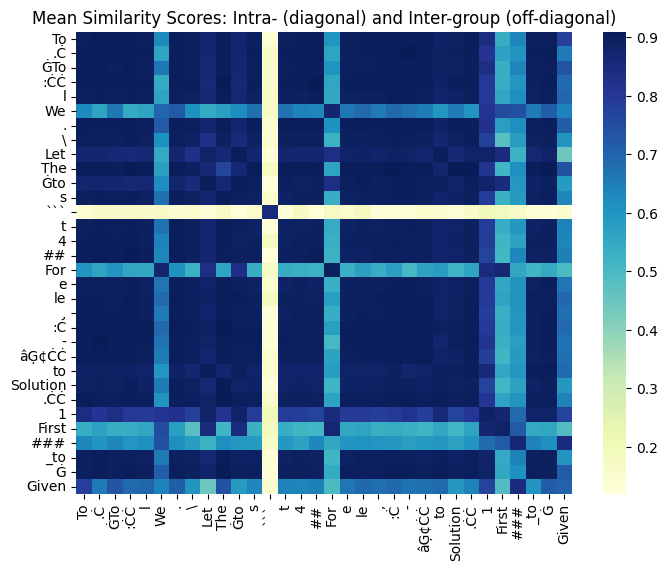

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare all prefixes and pairs
# prefixes = ["Given", "To", "We", "Let"]

# Initialize correlation matrix (prefix x prefix)
corr_matrix = pd.DataFrame(index=prefixes, columns=prefixes, dtype=float)

# Fill diagonal with intra-group similarity means
for prefix in prefixes:
    corr_matrix.loc[prefix, prefix] = np.median(intra_group_sim[prefix])

# Fill off-diagonal with inter-group similarity means
for p1 in prefixes:
    for p2 in prefixes:
        if p1 != p2:
            # inter_group_sim uses tuple with p1, p2 in sorted order
            pair = (p1, p2) if (p1, p2) in inter_group_sim else (p2, p1)
            if pair in inter_group_sim:
                corr_matrix.loc[p1, p2] = np.median(inter_group_sim[pair])
            else:
                # fallback (should not happen)
                corr_matrix.loc[p1, p2] = np.nan

# Plot correlation table as heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix.astype(float), annot=False, fmt=".3f", cmap="YlGnBu")
plt.title("Mean Similarity Scores: Intra- (diagonal) and Inter-group (off-diagonal)")
plt.show()
